# PennFudan Dataset Via

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
from glob import glob

In [2]:
ann = pd.read_csv('./PennFudanPed/Annotation/PennFudanVia.csv')
ann

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,0,"{""name"":""rect"",""x"":159,""y"":181,""width"":142,""he...","{""type"":""Pedestrian"",""occluded"":{}}"
1,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,1,"{""name"":""rect"",""x"":419,""y"":170,""width"":115,""he...","{""type"":""Pedestrian""}"
2,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,0,"{""name"":""rect"",""x"":67,""y"":92,""width"":123,""heig...","{""type"":""Pedestrian""}"
3,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,1,"{""name"":""rect"",""x"":145,""y"":99,""width"":82,""heig...","{""type"":""Pedestrian"",""occluded"":{""true"":true},..."
4,../PennFudanPed/PNGImages/FudanPed00003.png,-1,{},3,0,"{""name"":""rect"",""x"":304,""y"":134,""width"":142,""he...","{""type"":""Pedestrian""}"
...,...,...,...,...,...,...,...
529,../PennFudanPed/PNGImages/PennPed00094.png,-1,{},2,1,"{""name"":""rect"",""x"":28,""y"":274,""width"":93,""heig...","{""type"":""Pets"",""occluded"":{},""carry-on"":{}}"
530,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,0,"{""name"":""rect"",""x"":192,""y"":49,""width"":107,""hei...","{""type"":""Pedestrian"",""carry-on"":{""hand-bag"":tr..."
531,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,1,"{""name"":""rect"",""x"":319,""y"":54,""width"":112,""hei...","{""type"":""Pedestrian""}"
532,../PennFudanPed/PNGImages/PennPed00096.png,-1,{},2,0,"{""name"":""rect"",""x"":5,""y"":37,""width"":96,""height...","{""type"":""Pedestrian"",""carry-on"":{""backpack"":tr..."


In [3]:
import json
json.loads(ann.loc[3, 'region_attributes'])

{'type': 'Pedestrian',
 'occluded': {'true': True},
 'carry-on': {'backpack': True}}

# Dataset

In [4]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

In [5]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        # load all image files, sorting them to
        # ensure that they are aligned
        self.ann = pd.read_csv(os.path.join(root, 'Annotation', 'PennFudanVia.csv'))
        # standard transform
        self.raw_transforms = transforms.Compose([
            # fixed transform
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        self.transforms = transforms.Compose(transform.transforms + self.raw_transforms.transforms)
        self.types = TYPES
        self.carry_ons = CARRY_ONS

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, 'PNGImages', self.ann.loc[idx, 'filename'].split('/')[-1])
        img = Image.open(img_path).convert('RGB')
        # get bounding box coordinates for each mask
        num_objs = self.ann.loc[idx, 'region_count']
        box = json.loads(self.ann.loc[idx, 'region_shape_attributes'])
        attr = json.loads(self.ann.loc[idx, 'region_attributes'])

        t = [int(self.types.index(attr['type']))]
        o = [int(attr.get('occluded', {}).get('true', False))]
        c = [int(k in attr.get('carry-on', {}).keys()) for k in self.carry_ons]

        # normalize the boxes
        width, height = img.size

        tlx = box['x']
        tly = box['y']
        brx = tlx + box['width']
        bry = tly + box['height']
        box = torch.as_tensor([tlx, tly, brx, bry], dtype=torch.float32)

        target = {}
        target['id'] = torch.as_tensor(idx, dtype=torch.int16)
        target['raw'] = self.raw_transforms(img)
        target['box'] = box / torch.tensor([width, height] * 2)
        target['labels'] = torch.as_tensor(np.concatenate([t, o, c]), dtype=torch.uint8)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ann)

In [6]:
# construct dataset
transform = transforms.Compose([
    # custom transform
    transforms.Grayscale(1),
    transforms.RandomPosterize(4, 1.0),
    transforms.RandomEqualize(1.0),
])

root = './PennFudanPed'
dataset = PennFudanDataset(root, transform)

len(dataset)

534

In [7]:
def draw_box(image, bb, conf=None):
    # convert input to numpy arrays
    # need a copy of the image to function correctly
    img = image.numpy().transpose(1, 2, 0).copy()
    bb = bb.numpy()
    width, height = img.shape[:2]
    bb = np.floor(bb * np.array([height, width] * 2))

    # retrive the top-left & bottom-right corner
    tlx, tly, brx, bry = int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3])
    # cv2 draws the boxes inplace instead of returning a new image
    cv2.rectangle(img, (tlx, tly), (brx, bry), color=(1., 0, 0), thickness=2)

    # if conf is provided, show confidence score
    if conf is not None:
        txt = '{} ({:.2f})'.format(PENNFUDAN_LABEL_NAMES[1], conf[i])
        cv2.putText(img, txt, (tlx, tly - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (1., 0, 0), thickness=1)

    return img

In [8]:
def typeof(yt):
    t = yt['labels'][0]
    return TYPES[t]

def is_occluded(yt):
    o = yt['labels'][1]
    return o == 1

def carry_ons(yt):
    c = yt['labels'][2:]
    return ', '.join([CARRY_ONS[i] for i in range(len(c)) if c[i] == 1])

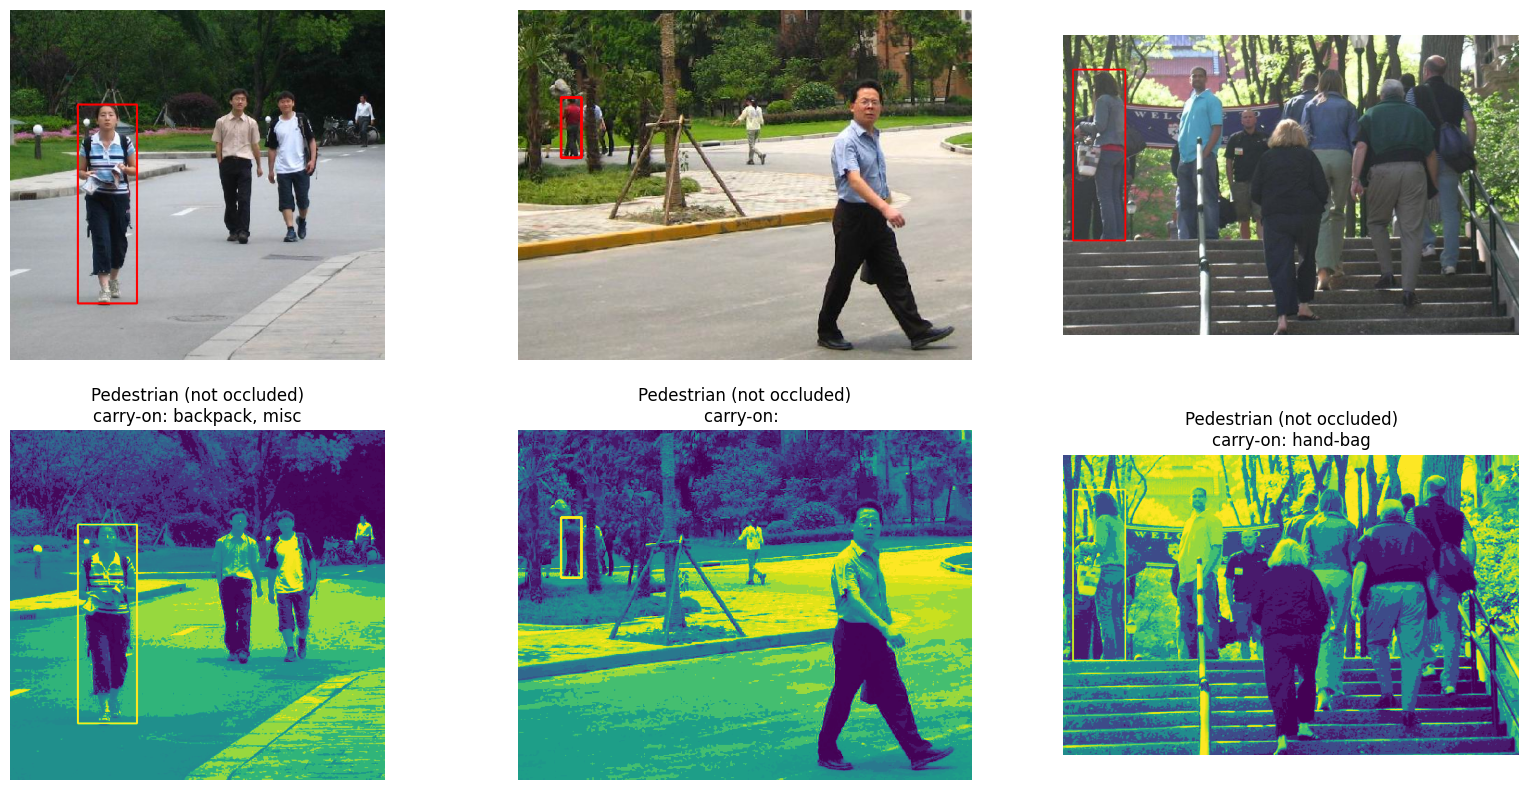

In [9]:
idx = np.random.choice(len(dataset), 3, replace=False)
#idx = np.random.choice(range(len(dataset)), 3, replace=False)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for ii, i in enumerate(idx):
    Xt, yt = dataset[i]
    title = '{} ({})\n{}'.format(
        typeof(yt), 'occluded' if is_occluded(yt) else 'not occluded',
        'carry-on: ' + carry_ons(yt)
    )
    ax[0][ii].imshow(draw_box(yt["raw"], yt['box']))
    ax[0][ii].axis('off')
    ax[1][ii].imshow(draw_box(Xt, yt['box']))
    ax[1][ii].axis('off')
    ax[1][ii].set_title(title)

In [28]:
ann[ann.loc[:, 'region_attributes'].apply(lambda x: x[9] != 'P')]

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
27,../PennFudanPed/PNGImages/FudanPed00009.png,-1,{},3,2,"{""name"":""rect"",""x"":444,""y"":149,""width"":12,""hei...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{}}"
37,../PennFudanPed/PNGImages/FudanPed00015.png,-1,{},6,1,"{""name"":""rect"",""x"":1,""y"":55,""width"":46,""height...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{}}"
38,../PennFudanPed/PNGImages/FudanPed00015.png,-1,{},6,2,"{""name"":""rect"",""x"":111,""y"":56,""width"":25,""heig...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{}}"
39,../PennFudanPed/PNGImages/FudanPed00015.png,-1,{},6,3,"{""name"":""rect"",""x"":131,""y"":49,""width"":21,""heig...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{""s..."
40,../PennFudanPed/PNGImages/FudanPed00015.png,-1,{},6,4,"{""name"":""rect"",""x"":48,""y"":57,""width"":13,""heigh...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{}}"
41,../PennFudanPed/PNGImages/FudanPed00015.png,-1,{},6,5,"{""name"":""rect"",""x"":237,""y"":48,""width"":8,""heigh...","{""type"":""Cyclist"",""occluded"":{""true"":true},""ca..."
46,../PennFudanPed/PNGImages/FudanPed00016.png,-1,{},8,4,"{""name"":""rect"",""x"":245,""y"":95,""width"":54,""heig...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{""s..."
47,../PennFudanPed/PNGImages/FudanPed00016.png,-1,{},8,5,"{""name"":""rect"",""x"":223,""y"":99,""width"":46,""heig...","{""type"":""Cyclist"",""occluded"":{""true"":true},""ca..."
48,../PennFudanPed/PNGImages/FudanPed00016.png,-1,{},8,6,"{""name"":""rect"",""x"":351,""y"":105,""width"":54,""hei...","{""type"":""Cyclist"",""occluded"":{""true"":true},""ca..."
52,../PennFudanPed/PNGImages/FudanPed00017.png,-1,{},4,2,"{""name"":""rect"",""x"":15,""y"":53,""width"":20,""heigh...","{""type"":""Cyclist"",""occluded"":{},""carry-on"":{}}"


## Crop

In [10]:
def get_object(image, bb, transform=None):
    w, h = image.shape[1], image.shape[2]
    bb = torch.floor(bb * torch.tensor([h, w, h, w])).int()

    ped = image[:, bb[1]:bb[3], bb[0]:bb[2]].clone()
    if transform:
        ped = transform(ped)

    return ped

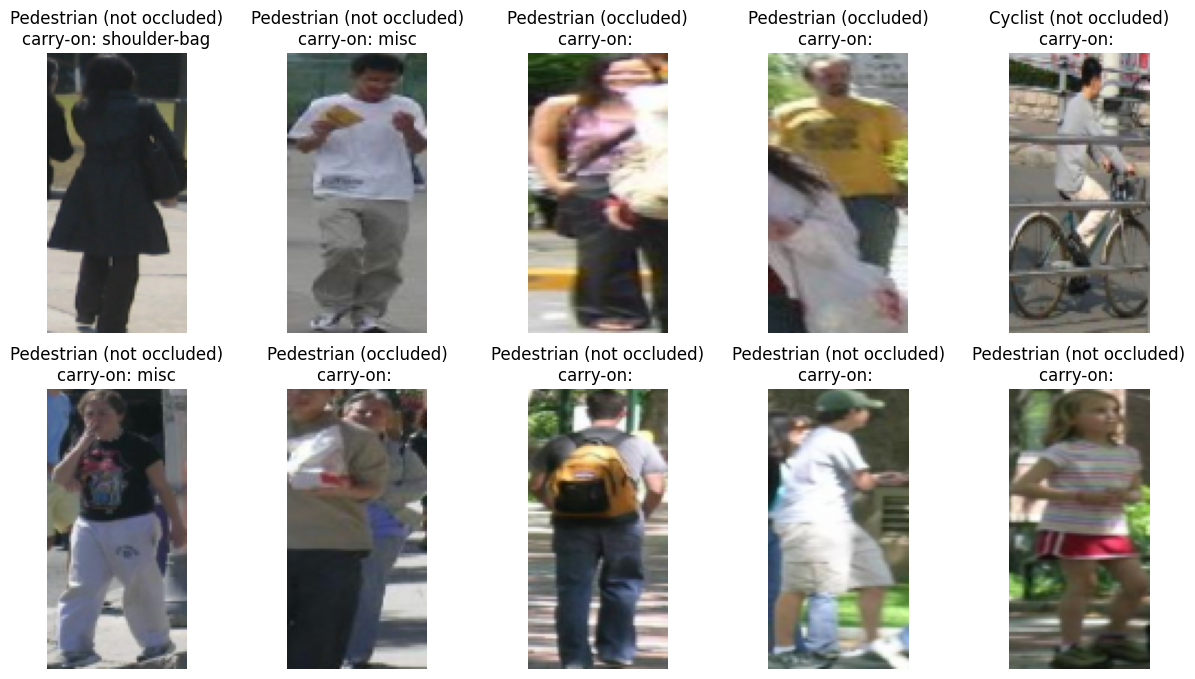

In [13]:
idx = np.random.choice(range(len(dataset)), 10, replace=False)
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
t = transforms.Resize((128, 64), antialias=True)

for i, ii in enumerate(idx):
    Xt, yt = dataset[ii]
    title = '{} ({})\n{}'.format(
        typeof(yt), 'occluded' if is_occluded(yt) else 'not occluded',
        'carry-on: ' + carry_ons(yt)
    )
    ped = get_object(yt['raw'], yt['box'], t)
    ax[i//5][i%5].imshow(ped.numpy().transpose(1, 2, 0))
    ax[i//5][i%5].axis('off')
    ax[i//5][i%5].set_title(title)

## Create Dicts

In [12]:
labels = {}
for i in range(len(dataset)):
    y = dataset[i][1]
    labels[y['id'].item()] = [y['id'].item()] + y['labels'].tolist()
labels = np.stack(list(zip(*sorted(labels.items())))[1])
np.save(root + 'labels.npy', labels)
print(labels.shape)

(534, 9)


In [13]:
labels = pd.DataFrame(
    np.load(root + 'labels.npy'),
    columns=['id', 'type', 'occluded'] + CARRY_ONS
).set_index('id')
labels

,type,occluded,backpack,shoulder-bag,hand-bag,luggage,umbrella,misc
id,,,,,,,,
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
529,2,0,0,0,0,0,0,0
530,0,0,0,0,1,0,0,0
531,0,0,0,0,0,0,0,0


In [14]:
labels['type'].value_counts()

type
0    511
1     22
2      1
Name: count, dtype: int64

In [18]:
cyc_ids = labels[labels['type'] == 1].index
cyc_ids

Index([ 27,  37,  38,  39,  40,  41,  46,  47,  48,  52,  64,  83, 116, 127,
       149, 150, 151, 152, 156, 157, 158, 164],
      dtype='int64', name='id')

In [29]:
peds = []
for i in cyc_ids:
    X, y = dataset[i]
    ped = get_object(X, y['box'], t).squeeze().numpy()
    peds.append(ped)
peds = np.stack(peds)
peds.shape

(22, 128, 64)

In [32]:
np.save('PennFudanPed/Dict/all_cyclists.npy', peds)

In [33]:
ped_ids = labels[labels['type'] == 0].index
ped_ids

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       523, 524, 525, 526, 527, 528, 530, 531, 532, 533],
      dtype='int64', name='id', length=511)

In [34]:
peds = []
for i in ped_ids:
    X, y = dataset[i]
    ped = get_object(X, y['box'], t).squeeze().numpy()
    peds.append(ped)
peds = np.stack(peds)
peds.shape

(511, 128, 64)

In [35]:
np.save('PennFudanPed/Dict/all_pedestrians.npy', peds)

### 128x64 All Samples

In [71]:
# split dataset
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-100])
test_set = torch.utils.data.Subset(dataset, indices[-100:])

len(train_set), len(test_set)

(434, 100)

In [74]:
# save all crops
root = 'PennFudanPed/ViaCrops/'
t = transforms.Resize((128, 64), antialias=True)

labels = {}
for i, (X, y) in enumerate(train_set):
    ped = get_object(X, y['box'], t).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze(), 'L')
    img.save(root + 'train/{:04}.png'.format(y['id'].item()))
    ped = get_object(y['raw'], y['box'], None).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze())
    img.save(root + 'train_raw/{:04}.png'.format(y['id'].item()))
    labels[y['id'].item()] = [y['id'].item()] + y['labels'].tolist()
    
labels = np.stack(list(zip(*sorted(labels.items())))[1])
np.save(root + 'train_labels.npy', labels)
print(labels.shape)

labels = {}
for i, (X, y) in enumerate(test_set):
    ped = get_object(X, y['box'], t).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze(), 'L')
    img.save(root + 'test/{:04}.png'.format(y['id'].item()))
    ped = get_object(y['raw'], y['box'], None).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze())
    img.save(root + 'test_raw/{:04}.png'.format(y['id'].item()))
    labels[y['id'].item()] = [y['id'].item()] + y['labels'].tolist()

labels = np.stack(list(zip(*sorted(labels.items())))[1])
np.save(root + 'test_labels.npy', labels)
print(labels.shape)

(434, 9)
(100, 9)


In [75]:
from glob import glob
train_imgs = sorted(glob(root + 'train/*.png'))
test_imgs = sorted(glob(root + 'test/*.png'))
len(train_imgs), len(test_imgs)

(434, 100)

In [76]:
train_dict = []
for i in train_imgs:
    train_dict.append(np.array(Image.open(i)))

test_dict = []
for i in test_imgs:
    test_dict.append(np.array(Image.open(i)))

train_dict = np.stack(train_dict, axis=0)
test_dict = np.stack(test_dict, axis=0)

mean = np.mean(train_dict, axis=0)
std = np.std(train_dict, axis=0)

eps = 1e-5
train_dict = (train_dict - mean) / std
test_dict = (test_dict - mean) / std

train_dict.shape, test_dict.shape

((434, 128, 64), (100, 128, 64))

In [77]:
np.save(root + 'train_dict.npy', train_dict)
np.save(root + 'test_dict.npy', test_dict)

### 64x32 Ped Non-Occ

In [15]:
ids = []
for i in range(len(dataset)):
    y = dataset[i][1]
    if typeof(y) == 'Pedestrian' and not is_occluded(y): ids.append(i)
len(ids)

386

In [16]:
indices = np.random.choice(ids, 200, replace=False)
train_set = torch.utils.data.Subset(dataset, indices)
test_set = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if i not in indices])
len(train_set), len(test_set)

(200, 334)

In [20]:
# save all crops
root = 'PennFudanPed/ViaCropsNOC/'
t = transforms.Compose([
    # custom transform
    #transforms.Normalize([0.5], [0.5]),
    #transforms.Pad((64, 64)),
    transforms.Resize((128, 64), antialias=True),
])

labels = {}
for i, (X, y) in enumerate(train_set):
    ped = get_object(X, y['box'], t).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze(), 'L')
    img.save(root + 'train/{:04}.png'.format(y['id'].item()))
    ped = get_object(y['raw'], y['box'], None).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze())
    img.save(root + 'train_raw/{:04}.png'.format(y['id'].item()))
    labels[y['id'].item()] = [y['id'].item()] + y['labels'].tolist()

labels = np.stack(list(zip(*sorted(labels.items())))[1])
np.save(root + 'train_labels.npy', labels)
print(labels.shape)

labels = {}
for i, (X, y) in enumerate(test_set):
    ped = get_object(X, y['box'], t).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze(), 'L')
    img.save(root + 'test/{:04}.png'.format(y['id'].item()))
    ped = get_object(y['raw'], y['box'], None).numpy().transpose(1, 2, 0) * 255
    img = Image.fromarray(ped.astype(np.uint8).squeeze())
    img.save(root + 'test_raw/{:04}.png'.format(y['id'].item()))
    labels[y['id'].item()] = [y['id'].item()] + y['labels'].tolist()

labels = np.stack(list(zip(*sorted(labels.items())))[1])
np.save(root + 'test_labels.npy', labels)
print(labels.shape)

(200, 9)
(334, 9)


In [21]:
from glob import glob
train_imgs = sorted(glob(root + 'train/*.png'))
test_imgs = sorted(glob(root + 'test/*.png'))
len(train_imgs), len(test_imgs)

(200, 334)

In [22]:
train_dict = []
for i in train_imgs:
    train_dict.append(np.array(Image.open(i)))

test_dict = []
for i in test_imgs:
    test_dict.append(np.array(Image.open(i)))

train_dict = np.stack(train_dict, axis=0)
test_dict = np.stack(test_dict, axis=0)

mean = np.mean(train_dict, axis=0)
std = np.std(train_dict, axis=0)

eps = 1e-8
train_dict = (train_dict - mean) / (std + eps)
test_dict = (test_dict - mean) / (std + eps)

train_dict.shape, test_dict.shape

((200, 128, 64), (334, 128, 64))

In [23]:
np.save(root + 'train_dict.npy', train_dict)
np.save(root + 'test_dict.npy', test_dict)